In [1]:
library(ReactomePA)
library(org.Sc.sgd.db)
library(clusterProfiler)
library(GOSim)
library(topGO)

Loading required package: DOSE

DOSE v3.0.10  For help: https://guangchuangyu.github.io/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609

ReactomePA v1.18.1  For help: https://guangchuangyu.github.io/ReactomePA

If you use ReactomePA in published research, please cite:
Guangchuang Yu, Qing-Yu He. ReactomePA: an R/Bioconductor package for reactome pathway analysis and visualization. Molecular BioSystems 2016, 12(2):477-479
Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, par

In [2]:
file <- "yeast_reactome"

ont <- "BP"
e_sg <- 0.8
e_en <- 0.3

db <- org.Sc.sgd.db
mapping <- "org.Sc.sgd.db"
ID <- "ENTREZID"

##load all community gene lists
setwd(sprintf("/home/david/Documents/ghsom/hierarchical_exploration_10000/%s_hierarchy_communities_%s_%s", file, e_sg, e_en))
# setwd(sprintf("/home/david/Desktop/%s_hierarchy_communities_%s", file, e_sg))

In [3]:
generateMap <- function(filename){
    map <- as.matrix(read.csv(filename, sep=",", header = F))
    communities <- map[,1]
    map <- map[,2:ncol(map)]
    rownames(map) <- communities
    colnames(map) <- communities
    return (map)
}

#background gene list
backgroundFilename <- "all_genes.txt"
allGenes <- scan(backgroundFilename, character())

##convert all genes to ENTREZID
conversion <- select(db, allGenes, "ENTREZID", "UNIPROT")
conversion <- subset(conversion, !duplicated(conversion$UNIPROT))
allGenes <- conversion$ENTREZID

#shortest path files
shortestPathFiles  <- list.files(pattern="*shortest_path*")

#shortest paths list
shortestPaths <- sapply(shortestPathFiles, generateMap)
names(shortestPaths) <- sapply(names(shortestPaths), function(name) strsplit(name, "_")[[1]][[1]])

#communitiy assignemtns
assignments <- as.matrix(read.csv("assignment_matrix.csv", sep=",", header=F, row.names=1, colClasses="character"))
assignments[assignments == ""] <- NA 
rownames(assignments) <- allGenes
colnames <- sapply(1:ncol(assignments), function(i) as.character(i - 1))
colnames(assignments) <- colnames
    
#filter out genes with no ENTREZID
assignments <- assignments[!is.na(rownames(assignments)),]
    
#all ORF identifers in org.Sc.sgd.db converted to EntrezID
allGenesInDB <- select(db, keys(db), "ENTREZID", "ORF")$ENTREZID
allGenesInDB <- allGenesInDB[!is.na(allGenesInDB)]
    
#communities detected
communities <- unique(as.character(assignments))
communities <- communities[communities != ""]
communities <- sort(communities)

'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns


In [4]:
communities

[1] "01"             "01-01"          "01-01-01"       "01-01-02"      
 [5] "01-01-02-01"    "01-01-02-01-01" "01-01-02-01-02" "01-01-02-01-03"
 [9] "01-01-02-02"    "01-01-02-03"    "01-01-03"       "01-01-04"      
[13] "01-01-04-01"    "01-01-04-02"    "01-01-04-03"    "01-02"         
[17] "01-02-01"       "01-02-01-01"    "01-02-01-02"    "01-02-01-03"   
[21] "01-02-01-03-01" "01-02-01-03-02" "01-02-01-03-03" "01-02-02"      
[25] "01-02-02-01"    "01-02-02-02"    "01-02-02-03"    "01-02-02-03-01"
[29] "01-02-02-03-02" "01-02-02-03-03" "01-02-03"       "01-02-03-01"   
[33] "01-02-03-02"    "01-02-03-03"    "01-03"          "01-03-01"      
[37] "01-03-01-01"    "01-03-01-02"    "01-03-01-03"    "01-03-01-03-01"
[41] "01-03-01-03-02" "01-03-01-03-03" "01-03-01-03-04" "01-03-01-03-05"
[45] "01-03-01-04"    "01-03-01-04-01" "01-03-01-04-02" "01-03-01-04-03"
[49] "01-03-01-05"    "01-03-02"       "01-03-02-01"    "01-03-02-02"   
[53] "01-03-02-03"    "01-03-02-03-01" "01-03-02-03-02" "01-03-02-03-03"
[57] "01-03-03"       "01-03-03-01"    "01-03-03-02"    "01-03-03-02-01"
[61] "01-03-03-02-02" "01-03-03-02-03" "01-03-03-03"    "01-03-03-03-01"
[65] "01-03-03-03-02" "01-03-03-03-03"

In [5]:
length(communities)

[1] 66

In [6]:
getDepth <- function(com) {
    return(which(apply(assignments, 2, function(i) any(i == com))))
}

getGenes <- function(com){
    depth <- getDepth(com)
    return(names(which(assignments[, depth] == com)))
}

getSubCommunities <- function(com){
    depth <- getDepth(com)
    genesInCommunity <- subset(assignments, assignments[,depth] == com)
    if (depth < ncol(genesInCommunity)){
        return(as.character(unique(genesInCommunity[,depth + 1])))
    } else {
        return (NULL)
    }
    
}
                       
getAllSubCommunities <- function(com){
    
    subCommunities <- getSubCommunities(com)
    if (NA %in% subCommunities){
        return(NULL)
    }
    q <- as.list(subCommunities)
    allSubCommunities <- subCommunities
    
    while (length(q) > 0){
        com <- q[[1]]
        q <- q[-1]
        subCommunities <- getSubCommunities(com)
        if (!NA %in% subCommunities){
            q <- append(q, subCommunities)
            allSubCommunities <- append(allSubCommunities, subCommunities)
        }
    }
    
    return(allSubCommunities)
    
}

getSuperCommunity <- function(com){
    depth <- getDepth(com)
    genesInCommunity <- subset(assignments, assignments[,depth] == com)
    return(as.character(unique(genesInCommunity[,depth - 1])))
}

getShortestPath <- function(com){
    return (try(shortestPaths[[com]]))
}
                       
getNeighbours <- function(com){
    
    superCommunity <- getSuperCommunity(com)
    superCommunityMap <- getShortestPath(superCommunity)
    v <- superCommunityMap[com, ] == 1
    return (names(v[v]))
    
}

In [7]:
genesInCommunities <- sapply(communities, function(i) getGenes(i))

In [8]:
allGenes <- allGenes[!is.na(allGenes)]

In [9]:
enrichmentResultsFile <- "enrichmentResults.rda"
if (!file.exists(enrichmentResultsFile)) {
       enrichmentResults <- sapply(genesInCommunities, 
                            function (genes) enrichPathway(gene = genes, organism = "yeast", minGSSize = 5,  
                                                           pAdjustMethod = "none"))
       names(enrichmentResults) <- communities
       save(enrichmentResults, file=enrichmentResultsFile)
        print("saving")
} else {
       load(enrichmentResultsFile)    
        print("loaded")
}

[1] "loaded"


In [11]:
df <- as.data.frame(enrichmentResults[["01"]])

In [14]:
head(df)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
1252265,1252265,Mitochondrial Protein Import (yeast),57/728,57/1145,2.675485e-12,2.675485e-12,3.380553e-10,850642/854231/852973/855602/854472/853585/855675/855082/854584/853600/856252/853639/856693/855705/855078/855732/855778/856395/850860/851981/851595/855751/850694/852916/855691/854790/851437/852177/856483/855243/853939/855669/856262/856419/852921/850963/856042/853812/855014/852388/854210/851309/853340/854950/853298/853093/853392/855654/851013/852688/850651/855592/854407/853540/855054/851380/852866,57
5719964,5719964,Mitochondrial protein import,57/728,57/1145,2.675485e-12,2.675485e-12,3.380553e-10,850642/854231/852973/855602/854472/853585/855675/855082/854584/853600/856252/853639/856693/855705/855078/855732/855778/856395/850860/851981/851595/855751/850694/852916/855691/854790/851437/852177/856483/855243/853939/855669/856262/856419/852921/850963/856042/853812/855014/852388/854210/851309/853340/854950/853298/853093/853392/855654/851013/852688/850651/855592/854407/853540/855054/851380/852866,57
5719401,5719401,"Cell Cycle, Mitotic",91/728,98/1145,3.233079e-12,3.233079e-12,3.380553e-10,856223/854810/852180/851461/856731/852071/853252/852385/852673/855459/852003/850977/855621/854776/850793/850613/854119/855362/856607/853147/850589/853003/853783/850554/854241/856422/850611/850864/856237/853002/856236/852037/855404/855052/852834/856830/852873/854411/851456/851408/854544/856742/854882/850980/850775/856680/853462/854059/855013/854735/852129/855201/853427/852245/850505/856130/851925/850907/851400/853168/856569/852383/852258/852457/854204/856305/854392/854284/856136/853712/853747/853821/854227/854435/854328/851557/851266/852239/853969/853531/852881/852865/854937/856218/854433/853456/853036/852501/854825/855426/851450,91
5719402,5719402,Cell Cycle,100/728,110/1145,7.810052e-12,7.810052e-12,6.124725e-10,856223/854810/855264/852180/851461/856731/852071/853252/852385/852673/856924/855459/855950/852003/850977/855621/854776/852700/850793/850613/854119/855362/856607/851676/853147/850589/853003/853783/850554/854241/856422/852577/850611/850864/856237/853002/856236/852037/855404/855052/852834/856830/852873/854411/851456/851408/854544/856742/854882/850980/850775/856680/853462/854059/855013/854735/852129/855201/853427/852245/850505/856130/851925/850907/851400/853168/856569/852383/852258/852457/854204/856305/854392/854284/856136/853712/853747/853821/854227/854435/852190/854328/851557/851266/852239/853969/853531/855471/852881/852865/854937/851975/856218/854433/853456/853036/852501/854825/855426/851450,100
5719443,5719443,Gene Expression,245/728,318/1145,1.473125e-09,1.473125e-09,9.241923e-08,851723/856223/851045/854810/851336/852254/852082/856388/855726/851058/853674/850592/850750/856312/851461/856317/852451/856547/854399/853301/853587/856731/854338/852071/851122/855981/856476/854263/851404/855155/852344/856024/854468/850998/851797/852955/855737/853842/850397/850839/850732/850882/851035/853632/856415/852003/854382/854791/853051/856217/856154/854301/852440/852185/852489/856593/855655/851830/856687/855283/855560/853557/854551/854663/856250/855302/854673/852833/853896/852775/854984/851990/855609/855571/855232/850613/855357/852665/854119/855362/856891/856607/854875/853147/852421/853997/854229/852853/853807/850554/851906/850764/856422/850611/855543/852487/851636/850864/855104/854385/856201/853161/851584/852888/852206/852037/852538/856316/854409/851104/852834/850682/852810/854855/856830/854434/852042/854956/852873/851575/854999/850691/850528/850827/851729/853931/852964/853123/855689/854283/854497/851408/854117/852305/855658/854544/852013/851484/851615/856742/856751/854882/852754/852938/852686/855276/856746/855972/854735/852296/854543/854939/856014/850994/854028/851895/856918/852922/855281/854933/854982/855415/855174/852026/856352/854980/854993/855320/853168/853529/851196/856026/854118/853840/851745/853713/855332/852495/850983/853463/851052/855480/854284/856136/853712/855925/852064/8522

In [15]:
pathways <- df$Description

In [16]:
genes <- df$geneID

In [23]:
genes <- sapply(genes, function(i) strsplit(i, "/"))

In [27]:
genes <- sapply(genes, function(i) select(db, i, "UNIPROT", "ENTREZID")$UNIPROT)
names(genes) <- pathways    

'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:1 mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys and columns
'select()' returned 1:many mapping between keys a

In [28]:
genes

$`Mitochondrial Protein Import (yeast)`
 [1] "Q3E731" "P07143" "P35180" "P07213" "Q08749" "P00830" "P00424" "P50110"
 [9] "P61829" "P57744" "P80967" "P36046" "O74700" "P53969" "P04710" "P00890"
[17] "P32378" "P87108" "P10507" "P32839" "Q04341" "P32897" "Q07914" "P27882"
[25] "P28834" "Q01852" "Q07540" "P07251" "P14693" "P23644" "P36147" "P04840"
[33] "Q06510" "P11914" "P53220" "P19882" "Q02776" "O60200" "Q03667" "P32830"
[41] "P33448" "Q12328" "P42949" "P00175" "P39515" "P53299" "P47045" "P53507"
[49] "P19414" "P04037" "Q12287" "P49334" "P38523" "P23641" "P40202" "P32891"
[57] "P53193"

$`Mitochondrial protein import`
 [1] "Q3E731" "P07143" "P35180" "P07213" "Q08749" "P00830" "P00424" "P50110"
 [9] "P61829" "P57744" "P80967" "P36046" "O74700" "P53969" "P04710" "P00890"
[17] "P32378" "P87108" "P10507" "P32839" "Q04341" "P32897" "Q07914" "P27882"
[25] "P28834" "Q01852" "Q07540" "P07251" "P14693" "P23644" "P36147" "P04840"
[33] "Q06510" "P11914" "P53220" "P19882" "Q02776" "O60200" "Q03667" "P32830"
[41] "P33448" "Q12328" "P42949" "P00175" "P39515" "P53299" "P47045" "P53507"
[49] "P19414" "P04037" "Q12287" "P49334" "P38523" "P23641" "P40202" "P32891"
[57] "P53193"

$`Cell Cycle, Mitotic`
 [1] "Q06103" "P40555" "P38170" "Q12377" "P22141" "Q03290" "P32944" "P15873"
 [9] "P53091" "P21951" "P33298" "Q06156" "P13382" "P15790" "Q08032" "P32496"
[17] "P40303" "P40302" "P38886" "P50086" "P38989" "P32943" "P32364" "P43588"
[25] "P06785" "P38764" "P30657" "P05759" "P30283" "P24868" "P24869" "Q04062"
[33] "P26754" "P23748" "Q01939" "P25451" "P21243" "P07807" "P15436" "Q12250"
[41] "P21242" "P40016" "P23639" "P29496" "Q12267" "P24279" "P46957" "P40339"
[49] "P32562" "P32565" "Q04410" "P32567" "P09938" "P38121" "P01123" "P30665"
[57] "Q06680" "P24871" "P24870" "P32379" "P38859" "P38251" "P29469" "P00546"
[65] "P38930" "P24482" "P38630" "P33297" "P37366" "P33299" "P26793" "P20457"
[73] "P19454" "Q08723" "P25043" "P40327" "P22336" "P23724" "P0CH08" "P0CH09"
[81] "P40348" "P53197" "P43639" "P54784" "P30656" "P53549" "P38624" "P23638"
[89] "P38132" "P10363" "P38629" "P06242"

$`Cell Cycle`
  [1] "Q06103" "P40555" "P32829" "P38170" "Q12377" "P22141" "Q03290" "P32944"
  [9] "P15873" "P53091" "P29311" "P21951" "P22216" "P33298" "Q06156" "P13382"
 [17] "P15790" "P46946" "Q08032" "P32496" "P40303" "P40302" "P38886" "P34730"
 [25] "P50086" "P38989" "P32943" "P32364" "P43588" "P06785" "P38764" "P38147"
 [33] "P30657" "P05759" "P30283" "P24868" "P24869" "Q04062" "P26754" "P23748"
 [41] "Q01939" "P25451" "P21243" "P07807" "P15436" "Q12250" "P21242" "P40016"
 [49] "P23639" "P29496" "Q12267" "P24279" "P46957" "P40339" "P32562" "P32565"
 [57] "Q04410" "P32567" "P09938" "P38121" "P01123" "P30665" "Q06680" "P24871"
 [65] "P24870" "P32379" "P38859" "P38251" "P29469" "P00546" "P38930" "P24482"
 [73] "P38630" "P33297" "P37366" "P33299" "P26793" "P20457" "P19454" "Q08723"
 [81] "P38110" "P25043" "P40327" "P22336" "P23724" "P0CH08" "P0CH09" "P40348"
 [89] "P12753" "P53197" "P43639" "P54784" "P33301" "P30656" "P53549" "P38624"
 [97] "P23638" "P38132" "P10363" "P38629" "P06242"

$`Gene Expression`
  [1] "Q03761" "Q06103" "P0C0T4" "P40555" "P0CX84" "P0CX85" "P0CX82" "P0CX83"
  [9] "P0C2H7" "P38754" "P41318" "P05743" "P05740" "P05747" "P05749" "P54999"
 [17] "Q12377" "P20435" "P20434" "P40422" "P20436" "P20433" "P26783" "P22141"
 [25] "Q3E7X9" "Q03290" "P0C2H9" "Q02939" "P38798" "P26786" "P25441" "P34160"
 [33] "P19735" "O13516" "Q08745" "P32502" "P32501" "P32914" "P32910" "P36014"
 [41] "P06367" "P43321" "P22217" "P49166" "P49167" "P32600" "P38711" "P33298"
 [49] "P22276" "P16370" "P24000" "P0C0W9" "P38431" "P32324" "P12385" "P38061"
 [57] "Q02753" "P38873" "P26785" "P23394" "P39990" "P0CX23" "P0CX24" "P0CX27"
 [65] "P0CX28" "P0CX25" "P0CX26" "P48589" "Q00578" "P0CX29" "P0CX30" "P38912"
 [73] "P26784" "P39936" "P14741" "P02406" "P02407" "P02400" "P28000" "P17890"
 [81] "P05745" "P32496" "P32497" "P32558" "P40303" "P40302" "P13393" "P38886"
 [89] "P11747" "P50086" "P323

In [32]:
cat(sapply(pathways, toString), file="pathways.csv", sep="\n")

In [31]:
cat(sapply(genes, toString), file="pathway_genes.csv", sep="\n")

In [29]:
write.csv(genes, file="pathway_genes.csv", sep=",")

Warning message in write.csv(genes, file = "pathway_genes.csv", sep = ","):
“attempt to set 'sep' ignored”

ERROR: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 57, 92, 101, 265, 63, 58, 50, 62, 61, 43, 40, 33, 37, 36, 38, 23, 45, 32, 39, 30, 25, 21, 16, 24, 20, 14, 18, 13, 17, 28, 64, 12, 11, 10, 9, 8, 90, 7


In [341]:
# nrow(as.data.frame(x))

In [342]:
# barplot(x, showCategory=10, title = "Top Enriched Pathways")

In [343]:
# dotplot(x, showCategory=15)

In [344]:
# enrichMap(x, layout=igraph::layout.kamada.kawai, vertex.label.cex = 1)

In [345]:
numbersOfEnrichedPathways <- sapply(enrichmentResults, function(i) nrow(as.data.frame(i)))
enrichedCommunities <- genesInCommunities[numbersOfEnrichedPathways > 0 & lengths(genesInCommunities) > 3]

In [346]:
numbersOfEnrichedPathways

01          01-01       01-01-01       01-01-02    01-01-02-01 
           115             29              0             13              1 
01-01-02-01-01 01-01-02-01-02 01-01-02-01-03    01-01-02-02    01-01-02-03 
             3              0              0              0             13 
      01-01-03       01-01-04    01-01-04-01    01-01-04-02    01-01-04-03 
             0              0              0              0              0 
         01-02       01-02-01    01-02-01-01    01-02-01-02    01-02-01-03 
            15              0              0             13              0 
01-02-01-03-01 01-02-01-03-02 01-02-01-03-03       01-02-02    01-02-02-01 
             0              0              2              8              0 
   01-02-02-02    01-02-02-03 01-02-02-03-01 01-02-02-03-02 01-02-02-03-03 
             0              3              0              2              0 
      01-02-03    01-02-03-01    01-02-03-02    01-02-03-03          01-03 
             0              0              0              0              8 
      01-03-01    01-03-01-01    01-03-01-02    01-03-01-03 01-03-01-03-01 
             0              0              0              0              0 
01-03-01-03-02 01-03-01-03-03 01-03-01-03-04 01-03-01-03-05    01-03-01-04 
             3              0             16              0             12 
01-03-01-04-01 01-03-01-04-02 01-03-01-04-03    01-03-01-05       01-03-02 
             0             22             21              2              0 
   01-03-02-01    01-03-02-02    01-03-02-03 01-03-02-03-01 01-03-02-03-02 
             0              0              2              0             26 
01-03-02-03-03       01-03-03    01-03-03-01    01-03-03-02 01-03-03-02-01 
             0              0              6              0              8 
01-03-03-02-02 01-03-03-02-03    01-03-03-03 01-03-03-03-01 01-03-03-03-02 
             0              0              0             13              0 
01-03-03-03-03 
             0

In [347]:
data.frame(numbersOfEnrichedPathways, lengths(genesInCommunities))

,numbersOfEnrichedPathways,lengths.genesInCommunities.
01,115,1131
01-01,29,279
01-01-01,0,36
01-01-02,13,143
01-01-02-01,1,88
01-01-02-01-01,3,10
01-01-02-01-02,0,48
01-01-02-01-03,0,30
01-01-02-02,0,46
01-01-02-03,13,9


In [348]:
res <- compareCluster(enrichedCommunities, 
                      fun="enrichPathway", universe = allGenesInDB, organism = "yeast", minGSSize = 5,  
                                                           pAdjustMethod = "none")

png(filename=sprintf("community_pathway_enrichment_all_communities.png"), width=1500)
plot(res)
dev.off()

png 
  2

In [349]:
plotPathwayEnrichments <- function(community){
    
#     subCommunities <- getAllSubCommunities(community)
    subCommunities <- getSubCommunities(community)
    
    if (!is.null(subCommunities) && !NA %in% subCommunities) {

        communitiesOfInterest <- c(community, subCommunities)
        genesOfInterest <- enrichedCommunities[communitiesOfInterest]
        genesOfInterest <- genesOfInterest[!is.na(names(genesOfInterest))]
        
        if (length(genesOfInterest) > 1) {
            res <- compareCluster(genesOfInterest, 
            fun="enrichPathway", organism = "yeast", minGSSize = 5,  pAdjustMethod = "none")

            png(filename=sprintf("community_pathway_enrichment_%s.png", community), 
                width=500 + length(genesOfInterest) * 150)
            print(plot(res))
            dev.off()
        } 
        
    }
    
    print(sprintf("completed %s", community))

}

In [350]:
sapply(communities, plotPathwayEnrichments)

[1] "completed 01"
[1] "completed 01-01"
[1] "completed 01-01-01"
[1] "completed 01-01-02"
[1] "completed 01-01-02-01"
[1] "completed 01-01-02-01-01"
[1] "completed 01-01-02-01-02"
[1] "completed 01-01-02-01-03"
[1] "completed 01-01-02-02"
[1] "completed 01-01-02-03"
[1] "completed 01-01-03"
[1] "completed 01-01-04"
[1] "completed 01-01-04-01"
[1] "completed 01-01-04-02"
[1] "completed 01-01-04-03"
[1] "completed 01-02"
[1] "completed 01-02-01"
[1] "completed 01-02-01-01"
[1] "completed 01-02-01-02"
[1] "completed 01-02-01-03"
[1] "completed 01-02-01-03-01"
[1] "completed 01-02-01-03-02"
[1] "completed 01-02-01-03-03"
[1] "completed 01-02-02"
[1] "completed 01-02-02-01"
[1] "completed 01-02-02-02"
[1] "completed 01-02-02-03"
[1] "completed 01-02-02-03-01"
[1] "completed 01-02-02-03-02"
[1] "completed 01-02-02-03-03"
[1] "completed 01-02-03"
[1] "completed 01-02-03-01"
[1] "completed 01-02-03-02"
[1] "completed 01-02-03-03"
[1] "completed 01-03"
[1] "completed 01-03-01"
[1] "completed 0

01                      01-01 
            "completed 01"          "completed 01-01" 
                  01-01-01                   01-01-02 
      "completed 01-01-01"       "completed 01-01-02" 
               01-01-02-01             01-01-02-01-01 
   "completed 01-01-02-01" "completed 01-01-02-01-01" 
            01-01-02-01-02             01-01-02-01-03 
"completed 01-01-02-01-02" "completed 01-01-02-01-03" 
               01-01-02-02                01-01-02-03 
   "completed 01-01-02-02"    "completed 01-01-02-03" 
                  01-01-03                   01-01-04 
      "completed 01-01-03"       "completed 01-01-04" 
               01-01-04-01                01-01-04-02 
   "completed 01-01-04-01"    "completed 01-01-04-02" 
               01-01-04-03                      01-02 
   "completed 01-01-04-03"          "completed 01-02" 
                  01-02-01                01-02-01-01 
      "completed 01-02-01"    "completed 01-02-01-01" 
               01-02-01-02                01-02-01-03 
   "completed 01-02-01-02"    "completed 01-02-01-03" 
            01-02-01-03-01             01-02-01-03-02 
"completed 01-02-01-03-01" "completed 01-02-01-03-02" 
            01-02-01-03-03                   01-02-02 
"completed 01-02-01-03-03"       "completed 01-02-02" 
               01-02-02-01                01-02-02-02 
   "completed 01-02-02-01"    "completed 01-02-02-02" 
               01-02-02-03             01-02-02-03-01 
   "completed 01-02-02-03" "completed 01-02-02-03-01" 
            01-02-02-03-02             01-02-02-03-03 
"completed 01-02-02-03-02" "completed 01-02-02-03-03" 
                  01-02-03                01-02-03-01 
      "completed 01-02-03"    "completed 01-02-03-01" 
               01-02-03-02                01-02-03-03 
   "completed 01-02-03-02"    "completed 01-02-03-03" 
                     01-03                   01-03-01 
         "completed 01-03"       "completed 01-03-01" 
               01-03-01-01                01-03-01-02 
   "completed 01-03-01-01"    "completed 01-03-01-02" 
               01-03-01-03             01-03-01-03-01 
   "completed 01-03-01-03" "completed 01-03-01-03-01" 
            01-03-01-03-02             01-03-01-03-03 
"completed 01-03-01-03-02" "completed 01-03-01-03-03" 
            01-03-01-03-04             01-03-01-03-05 
"completed 01-03-01-03-04" "completed 01-03-01-03-05" 
               01-03-01-04             01-03-01-04-01 
   "completed 01-03-01-04" "completed 01-03-01-04-01" 
            01-03-01-04-02             01-03-01-04-03 
"completed 01-03-01-04-02" "completed 01-03-01-04-03" 
               01-03-01-05                   01-03-02 
   "completed 01-03-01-05"       "completed 01-03-02" 
               01-03-02-01                01-03-02-02 
   "completed 01-03-02-01"    "completed 01-03-02-02" 
               01-03-02-03             01-03-02-03-01 
   "completed 01-03-02-03" "completed 01-03-02-03-01" 
            01-03-02-03-02             01-03-02-03-03 
"completed 01-03-02-03-02" "completed 01-03-02-03-03" 
                  01-03-03                01-03-03-01 
      "completed 01-03-03"    "completed 01-03-03-01" 
               01-03-03-02             01-03-03-02-01 
   "completed 01-03-03-02" "completed 01-03-03-02-01" 
            01-03-03-02-02             01-03-03-02-03 
"completed 01-03-03-02-02" "completed 01-03-03-02-03" 
               01-03-03-03             01-03-03-03-01 
   "completed 01-03-03-03" "completed 01-03-03-03-01" 
            01-03-03-03-02             01-03-03-03-03 
"completed 01-03-03-03-02" "completed 01-03-03-03-03"

In [352]:
factorClusters <- lapply(enrichedCommunities, function(genes) {
    f <- factor(as.integer(allGenesInDB%in%genes))
    names(f) <- allGenesInDB
    return(f)
})

In [353]:
coms <- factorClusters[getSubCommunities("01")]
m1 <- compareCluster(coms[!is.na(names(coms))], fun="enrichGO", 
                     OrgDb=mapping, minGSSize = 5,  pAdjustMethod = "none")

ERROR: Error in compareCluster(coms[!is.na(names(coms))], fun = "enrichGO", OrgDb = mapping, : No enrichment found in any of gene cluster, please check your input...


In [ ]:
compareCluster(c(getGenes("01-02-02-02"), getGenes("01-02-02-03")), fun="groupGO", OrgDb=mapping)

In [42]:
# viewPathway(pathName = "Nonsense Mediated Decay (NMD) enhanced by the Exon Junction Complex (EJC)", 
#             organism = "yeast", readable = F)

In [258]:
setOntology(ont, loadIC=TRUE)
setEvidenceLevel(evidences="all", organism=org.Sc.sgdORGANISM, gomap=org.Sc.sgdGO)

initializing GOSim package ...
-> retrieving GO information for all available genes for organism 'human' in GO database
-> filtering GO terms according to evidence levels 'all'
-> loading files with information content for corresponding GO category (human)
finished.
-> loading files with information content for corresponding GO category (human)
-> retrieving GO information for all available genes for organism 'Saccharomyces cerevisiae' in GO database
-> filtering GO terms according to evidence levels 'all'


In [57]:
allGenesORF <- keys(db)


GOenrichmentResults <- sapply(genesInCommunities, function(genesOfInterest) {
    
    conversionTable <- select(db, genesOfInterest, "ORF", "ENTREZID")
    
    GOenrichment(conversionTable$ORF, allGenesORF, cutoff=0.05, method="weight01")
}
)

'select()' returned many:1 mapping between keys and columns

Building most specific GOs .....
	( 2909 GO terms found. )

Build GO DAG topology ..........
	( 5064 GO terms and 11404 relations. )

Annotating nodes ...............
	( 6419 genes annotated to the GO terms. )

			 -- Weight01 Algorithm -- 

		 the algorithm is scoring 3195 nontrivial nodes
		 parameters: 
			 test statistic: fisher

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	12 nodes to be scored	(0 eliminated genes)

	 Level 15:	36 nodes to be scored	(2 eliminated genes)

	 Level 14:	75 nodes to be scored	(40 eliminated genes)

	 Level 13:	138 nodes to be scored	(213 eliminated genes)

	 Level 12:	186 nodes to be scored	(516 eliminated genes)

	 Level 11:	281 nodes to be scored	(1014 eliminated genes)

	 Level 10:	380 nodes to be scored	(1600 eliminated genes)

	 Level 9:	447 nodes to be scored	(2277 eliminated genes)

	 Level 8:	405 nodes to be scored	(3043 eliminated genes)

	 Level 7:	413 nodes to

In [58]:
rownames(GOenrichmentResults) <- c("terms", "p-values", "genes")
colnames(GOenrichmentResults) <- communities

In [59]:
GOenrichmentResults[["terms", "01-05"]]

,go_id,Term,Definition
418,GO:0000173,inactivation of MAPK activity involved in osmosensory signaling pathway,Any process that terminates the activity of the active enzyme MAP kinase during osmolarity sensing.
2443,GO:0001732,formation of cytoplasmic translation initiation complex,"Joining of the large subunit, with release of IF2/eIF2 and IF3/eIF3. This leaves the functional ribosome at the AUG, with the methionyl/formyl-methionyl-tRNA positioned at the P site."
3403,GO:0002181,cytoplasmic translation,The chemical reactions and pathways resulting in the formation of a protein in the cytoplasm. This is a ribosome-mediated process in which the information in messenger RNA (mRNA) is used to specify the sequence of amino acids in the protein.
6111,GO:0006386,termination of RNA polymerase III transcription,The process in which transcription by RNA polymerase III is terminated; Pol III has an intrinsic ability to terminate transcription upon incorporation of 4 to 6 contiguous U residues.
14416,GO:0005980,glycogen catabolic process,"The chemical reactions and pathways resulting in the breakdown of glycogen, a polydisperse, highly branched glucan composed of chains of D-glucose residues."
14736,GO:0006089,lactate metabolic process,"The chemical reactions and pathways involving lactate, the anion of lactic acid."
14802,GO:0055114,oxidation-reduction process,"A metabolic process that results in the removal or addition of one or more electrons to or from a substance, with or without the concomitant removal or addition of a proton or protons."
15014,GO:0006189,'de novo' IMP biosynthetic process,"The chemical reactions and pathways resulting in the formation of IMP, inosine monophosphate, by the stepwise assembly of a purine ring on ribose 5-phosphate."
16138,GO:0006696,ergosterol biosynthetic process,"The chemical reactions and pathways resulting in the formation of ergosterol, (22E)-ergosta-5,7,22-trien-3-beta-ol, a sterol found in ergot, yeast and moulds."
16345,GO:0006744,ubiquinone biosynthetic process,"The chemical reactions and pathways resulting in the formation of ubiquinone, a lipid-soluble electron-transporting coenzyme."


In [60]:
getSubCommunities("01-05")

[1] NA

In [61]:
GOenrichmentResults[["terms", "01-05-08"]]

ERROR: Error in GOenrichmentResults[["terms", "01-05-08"]]: subscript out of bounds


In [ ]:
getGenes("01-05")

In [259]:
library(GOSemSim)

GOSemSim v2.0.4  For help: https://guangchuangyu.github.io/GOSemSim

If you use GOSemSim in published research, please cite:
Guangchuang Yu, Fei Li, Yide Qin, Xiaochen Bo, Yibo Wu, Shengqi Wang. GOSemSim: an R package for measuring semantic similarity among GO terms and gene products Bioinformatics 2010, 26(7):976-978

Attaching package: ‘GOSemSim’

The following objects are masked from ‘package:DOSE’:

    clusterSim, geneSim, mclusterSim



In [260]:
scGO <- godata(OrgDb = mapping, keytype = ID, ont = ont)

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


In [ ]:
clusterSimFile <- "clusterSimilarity.rda"
if (!file.exists(clusterSimFile)){
    clusterSim <- mclusterSim(clusters=genesInCommunities, semData=scGO)
    save(clusterSim, file=clusterSimFile)
    print("saved")
} else {
    load(clusterSimFile)
    print("loaded")
}

In [262]:
communitiesOfInterest <- c(getSubCommunities("01"), getSubCommunities("01-02"))

In [264]:
length(communitiesOfInterest)

[1] 18

In [266]:
clusterSim <- mclusterSim(clusters=genesInCommunities[communitiesOfInterest], semData=scGO)

In [267]:
clusterSim

,01-02,01-06,01-03,01-05,01-01,01-04,01-07,01-08,01-02-02,01-02-01,01-02-06,01-02-03,01-02-05,01-02-09,01-02-04,01-02-08,01-02-07,01-02-10
01-02,1.000,0.675,0.828,0.659,0.741,0.581,0.542,0.450,0.821,0.961,0.611,0.761,0.742,0.683,0.718,0.651,0.606,0.601
01-06,0.675,1.000,0.718,0.753,0.716,0.621,0.573,0.525,0.724,0.692,0.656,0.711,0.729,0.695,0.743,0.723,0.664,0.665
01-03,0.828,0.718,1.000,0.713,0.774,0.612,0.567,0.480,0.814,0.834,0.654,0.786,0.767,0.744,0.738,0.690,0.644,0.657
01-05,0.659,0.753,0.713,1.000,0.703,0.626,0.563,0.543,0.711,0.680,0.670,0.730,0.708,0.702,0.713,0.724,0.705,0.719
01-01,0.741,0.716,0.774,0.703,1.000,0.654,0.589,0.482,0.754,0.755,0.656,0.756,0.747,0.709,0.739,0.708,0.654,0.657
01-04,0.581,0.621,0.612,0.626,0.654,1.000,0.598,0.502,0.626,0.599,0.577,0.662,0.657,0.602,0.615,0.645,0.589,0.637
01-07,0.542,0.573,0.567,0.563,0.589,0.598,1.000,0.428,0.585,0.555,0.558,0.607,0.581,0.572,0.575,0.585,0.543,0.545
01-08,0.450,0.525,0.480,0.543,0.482,0.502,0.428,1.000,0.508,0.464,0.472,0.485,0.482,0.478,0.479,0.563,0.500,0.514
01-02-02,0.821,0.724,0.814,0.711,0.754,0.626,0.585,0.508,1.000,0.812,0.637,0.809,0.758,0.728,0.738,0.707,0.646,0.671
01-02-01,0.961,0.692,0.834,0.680,0.755,0.599,0.555,0.464,0.812,1.000,0.620,0.770,0.738,0.690,0.713,0.657,0.612,0.610


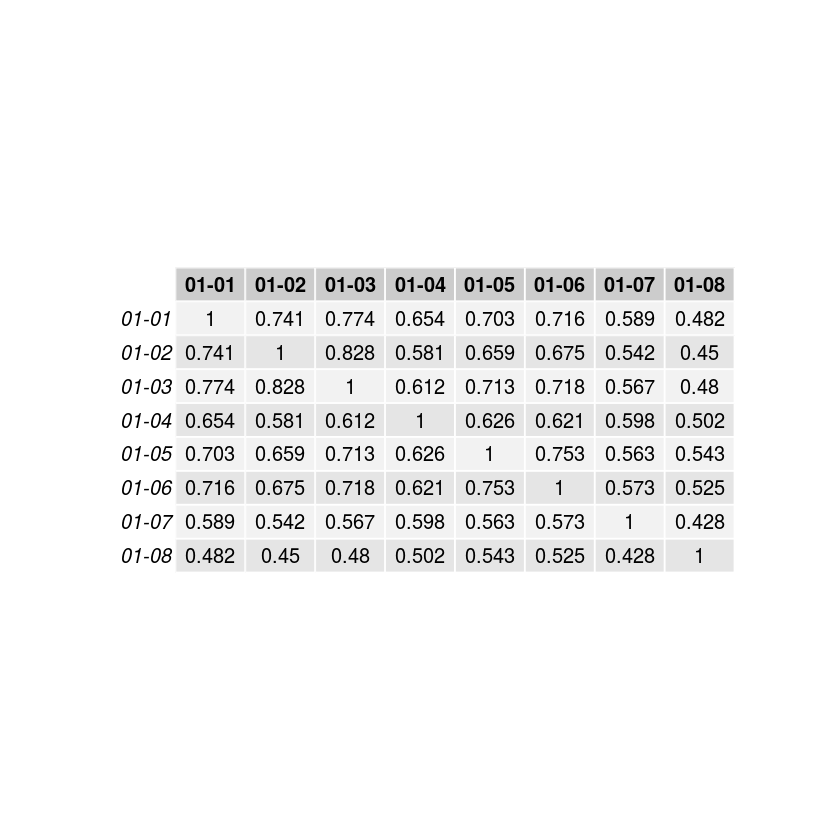

In [269]:
library(gridExtra)
grid.table(clusterSim[sort(getSubCommunities("01")),sort(getSubCommunities("01"))])

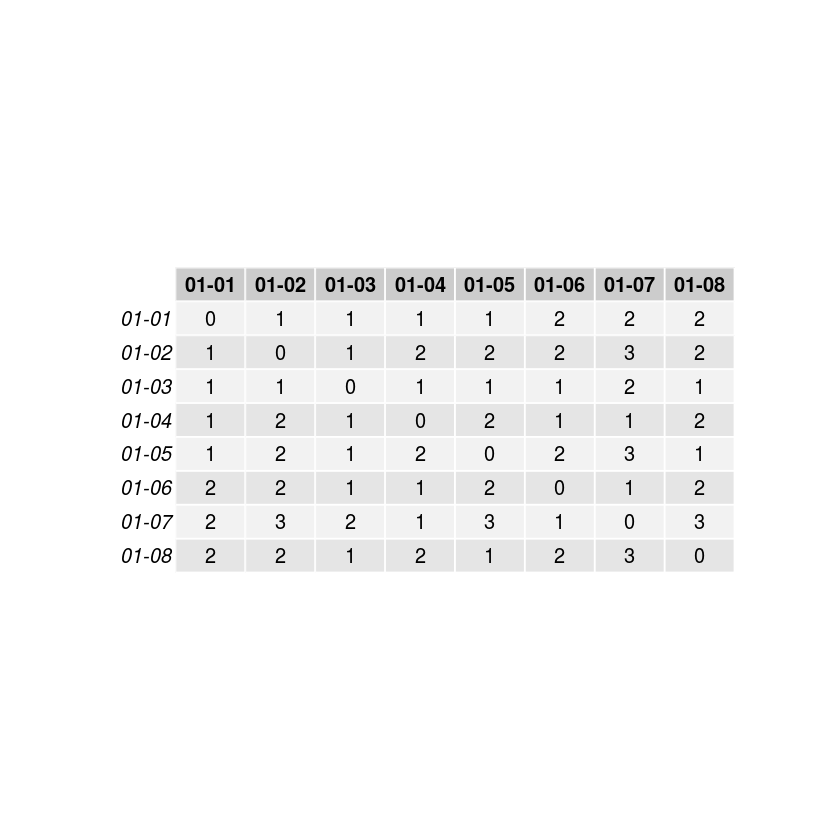

In [270]:
grid.table(getShortestPath("01"))

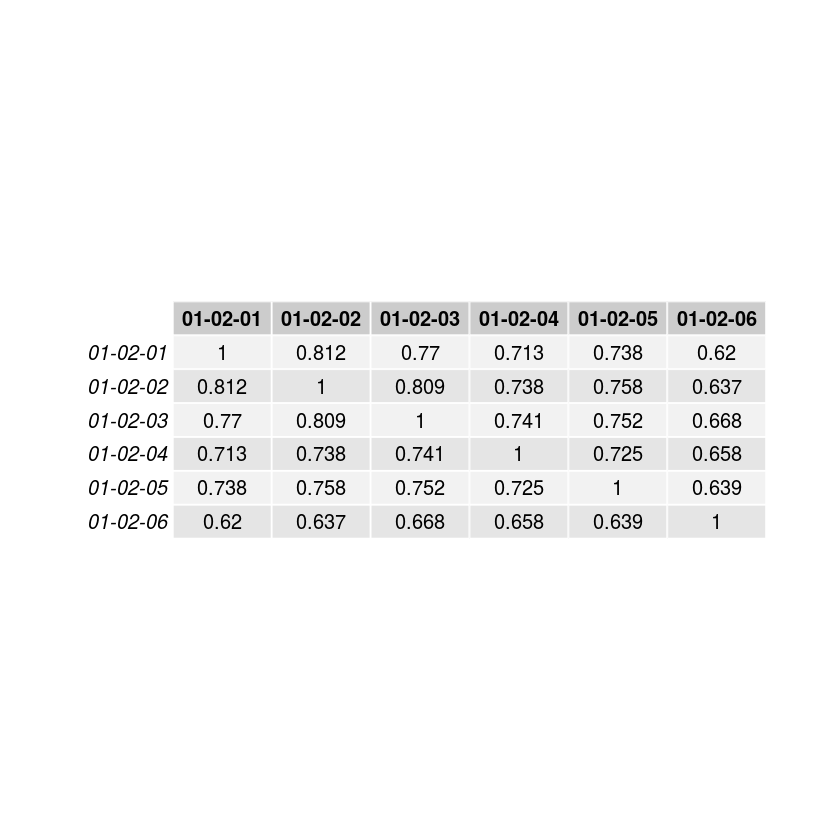

In [282]:
grid.table(clusterSim[sort(getSubCommunities("01-02"))[1:6],sort(getSubCommunities("01-02"))[1:6]])

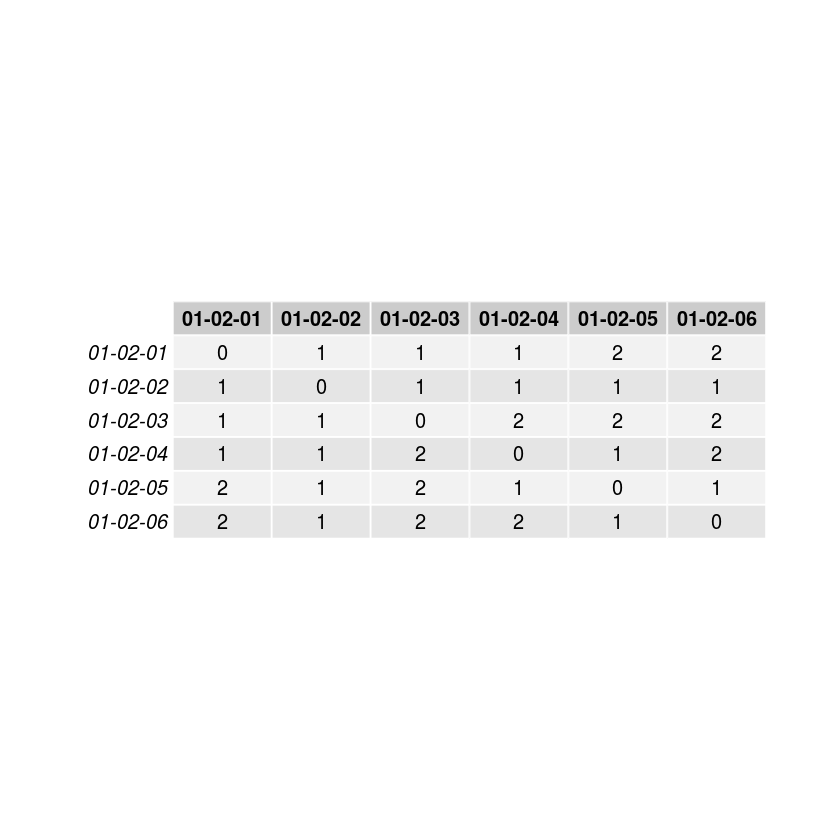

In [283]:
grid.table(getShortestPath("01-02")[1:6, 1:6])